In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
#   LEARN FCN00
#

from __future__ import print_function
import argparse
import os

import numpy as np
import pickle
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, AveragePooling2D
from keras.layers import merge
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import list_pictures, array_to_img

from image_ext import list_pictures_in_multidir, load_imgs_asarray, img_dice_coeff, get_center
from fname_func import load_fnames, make_fnames

# MAXPOOLING
from create_fcn import create_fcn01, create_fcn00
# AVERAGE POOLING
#from create_fcn_avpool import create_fcn01,create_fcn00

np.random.seed(2016)

Using TensorFlow backend.


In [2]:
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2.*intersection + 1) / (K.sum(y_true) + K.sum(y_pred) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [5]:
#
#  MAIN STARTS FROM HERE
#
if __name__ == '__main__':
    
    target_size = (224, 224)
    dpath_this = './'
    # dname_checkpoints = 'checkpoints_fcn00_avpool.augumented'
    dname_checkpoints = 'checkpoints_fcn00.augumented'
    # dname_checkpoints_fcn01 = 'checkpoints_fcn01_avpool'
    dname_checkpoints_fcn01 = 'checkpoints_fcn01'
    dname_outputs = 'outputs'
    fname_architecture = 'architecture.json'
    fname_weights = "model_weights_{epoch:02d}.h5"
    fname_stats = 'stats01.npz'
    dim_ordering = 'channels_first'
    fname_history = "history.pkl"

    # definision of mode, LEARN or TEST or SHOW_HISTORY
    #mode = "LEARN"
    #mode = "SHOW_HISTORY"
    #mode = "TEST"

    # モデルを作成
    print('creating model fcn00...')
    model_fcn00 = create_fcn00(target_size)

creating model fcn00...


In [ ]:
    #
    # Test UBIRIS Data
    #
    fnames = load_fnames('data/list_test_01.txt')
    [fpaths_xs_test,fpaths_ys_test] = make_fnames(fnames,'data/img','data/mask','OperatorA_')
    
    X_test = load_imgs_asarray(fpaths_xs_test, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    Y_test = load_imgs_asarray(fpaths_ys_test, grayscale=True, target_size=target_size,
                                dim_ordering=dim_ordering)

    # Yを初期化
    center_test = []
    for i in range(Y_test.shape[0]):
        center_test.append(get_center(Y_test[i,0,:,:]))
    center_test = np.array(center_test)

    # トレーニング時に計算した平均・標準偏差をロード    
    print('loading mean and standard deviation from ' + fname_stats + '...')
    stats = np.load(dname_checkpoints + '/' + fname_stats)
    mean = stats['mean']
    std = stats['std']
    print('==> mean: ' + str(mean))
    print('==> std : ' + str(std))

    for i in range(3):
        X_test[:, i] = (X_test[:, i] - mean[i]) / std[i]
    print('==> done')

    # test epoch 50, 100, 150, 200
    for epoch in range(50,201,50):
        # 学習済みの重みをロード
        fname_weights = 'model_weights_%02d.h5'%(epoch)
        fpath_weights = os.path.join(dname_checkpoints, fname_weights)
        model_fcn00.load_weights(fpath_weights)
        print('==> done loading data %d'%(epoch))
        
        # テストを開始
        outputs = model_fcn00.predict(X_test)
        
        # 出力を画像として保存
        dname_outputs = './outputs/'
        if not os.path.isdir(dname_outputs):
            print('create directory: %s'%(dname_outputs))
            os.mkdir(dname_outputs)
            
        print('saving outputs as images...')
        for i, array in enumerate(outputs):
            array = np.where(array > 0.1, 1, 0) # 二値に変換
            array = array.astype(np.float32)
            img_out = array_to_img(array, dim_ordering)
            # fpath_out = os.path.join(dname_outputs, fnames[i])
            fpath_out = os.path.join(dname_outputs, "%05d.png"%(i))
            img_out.save(fpath_out)

        print('==> done')
        
        dice_eval = []
        center_gt = []
        center_estimated = []
        
        for i in range(len(fpaths_xs_test)):
            # 出力結果
            im2 = Image.open(os.path.join(dname_outputs, "%05d.png"%(i)))
            im2 = im2.resize(target_size)
            # Grond Truth
            im3 = Image.open(fpaths_ys_test[i])
            im3 = im3.resize(target_size)

            im2a = np.array(im2)
            im2a[im2a > 0] = 1
            im3a = np.array(im3)
            im3a[im3a > 0] = 1

            overlap_a = np.array(im2a) * np.array(im3a)
            overlap_b = np.array(im2a) + np.array(im3a)
            dice_eval.append(2*sum(sum(overlap_a))/sum(sum(overlap_b)))

            c1 = get_center(get_center(np.array(im2a)))
            c2 = get_center(get_center(np.array(im3a)))

            print('%d: Dice eval : %f'%(i,2*sum(sum(overlap_a))/sum(sum(overlap_b))))
            print('    Estimated (%f,%f) - GT (%f,%f)'%(c1[0],c1[1],c2[0],c2[1]))

            center_gt.append(c2)
            center_estimated.append(c1)
        
        diff = np.array(center_gt) - np.array(center_estimated)
    
        print('%d: Dice eval av. : %f'%(epoch,np.mean(np.array(dice_eval))))
        print('Av. diff = %f, %f'%(np.sum(diff[:,0])/diff.shape[0],np.sum(diff[:,1])/diff.shape[0]))

==> done
saving outputs as images...
==> done
0: Dice eval : 0.819058
data.nnlab/image/fujiwara0509.png
(240, 320, 3)
(240, 320, 3)


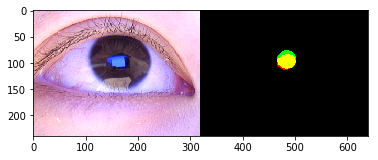

1: Dice eval : 0.816017
data.nnlab/image/fujiwara0565.png
(240, 320, 3)
(240, 320, 3)


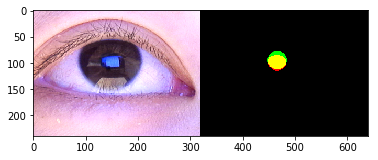

2: Dice eval : 0.784983
data.nnlab/image/fujiwara0621.png
(240, 320, 3)
(240, 320, 3)


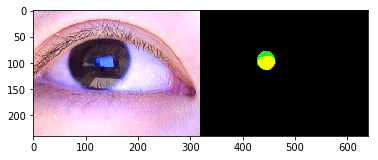

3: Dice eval : 0.787211
data.nnlab/image/fujiwara0702.png
(240, 320, 3)
(240, 320, 3)


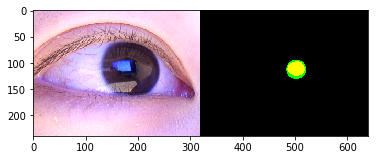

4: Dice eval : 0.890146
data.nnlab/image/fujiwara0757.png
(240, 320, 3)
(240, 320, 3)


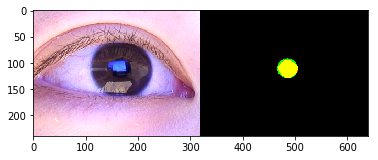

5: Dice eval : 0.931119
data.nnlab/image/fujiwara0845.png
(240, 320, 3)
(240, 320, 3)


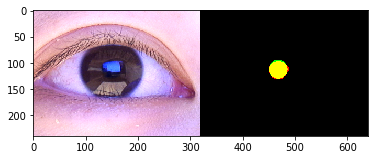

6: Dice eval : 0.851724
data.nnlab/image/fujiwara0892.png
(240, 320, 3)
(240, 320, 3)


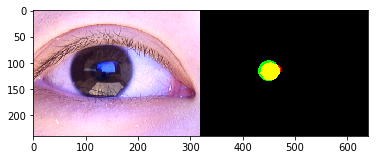

7: Dice eval : 0.691765
data.nnlab/image/higuchi0519.png
(240, 320, 3)
(240, 320, 3)


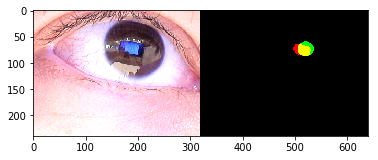

8: Dice eval : 0.684253
data.nnlab/image/higuchi0679.png
(240, 320, 3)
(240, 320, 3)


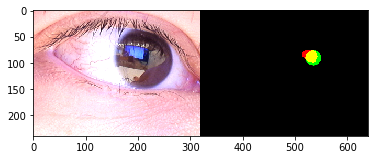

9: Dice eval : 0.694006
data.nnlab/image/higuchi0727.png
(240, 320, 3)
(240, 320, 3)


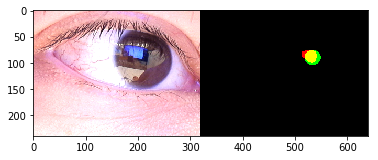

10: Dice eval : 0.729781
data.nnlab/image/higuchi0762.png
(240, 320, 3)
(240, 320, 3)


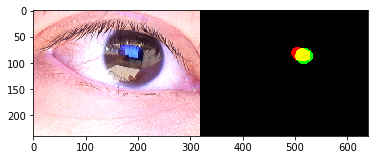

11: Dice eval : 0.819718
data.nnlab/image/higuchi0862.png
(240, 320, 3)
(240, 320, 3)


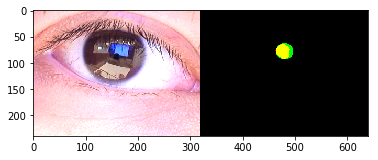

12: Dice eval : 0.721678
data.nnlab/image/kitazumi0415.png
(240, 320, 3)
(240, 320, 3)


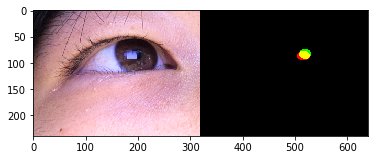

13: Dice eval : 0.703333
data.nnlab/image/kitazumi0443.png
(240, 320, 3)
(240, 320, 3)


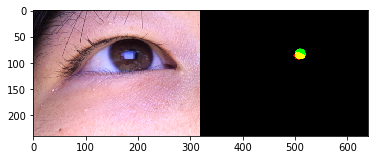

14: Dice eval : 0.759055
data.nnlab/image/kitazumi0507.png
(240, 320, 3)
(240, 320, 3)


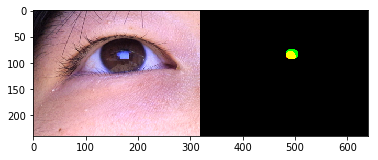

15: Dice eval : 0.683871
data.nnlab/image/kitazumi0578.png
(240, 320, 3)
(240, 320, 3)


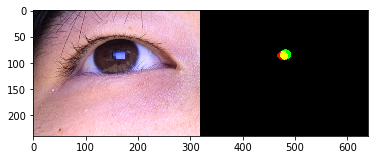

16: Dice eval : 0.777595
data.nnlab/image/kitazumi0670.png
(240, 320, 3)
(240, 320, 3)


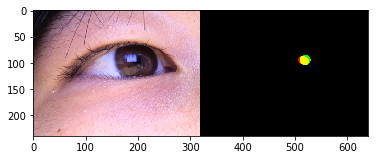

17: Dice eval : 0.646109
data.nnlab/image/kitazumi0685.png
(240, 320, 3)
(240, 320, 3)


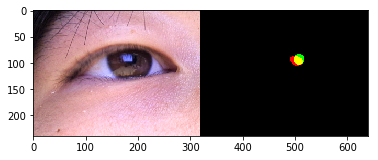

18: Dice eval : 0.888189
data.nnlab/image/kitazumi0786.png
(240, 320, 3)
(240, 320, 3)


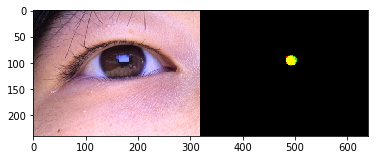

19: Dice eval : 0.000000
data.nnlab/image/matsuda0382.png
(240, 320, 3)
(240, 320, 3)


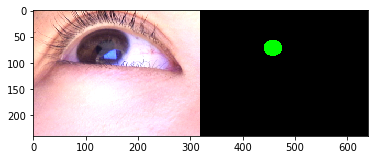

20: Dice eval : 0.000000
data.nnlab/image/matsuda0431.png
(240, 320, 3)
(240, 320, 3)


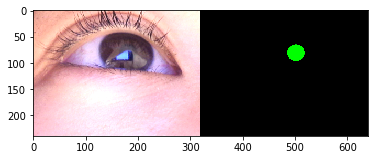

21: Dice eval : 0.000000
data.nnlab/image/matsuda0499.png
(240, 320, 3)
(240, 320, 3)


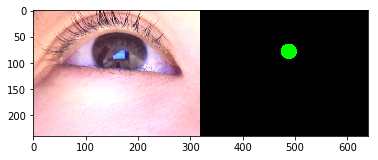

22: Dice eval : 0.000000
data.nnlab/image/matsuda0559.png
(240, 320, 3)
(240, 320, 3)


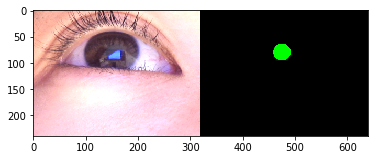

23: Dice eval : 0.000000
data.nnlab/image/matsuda0634.png
(240, 320, 3)
(240, 320, 3)


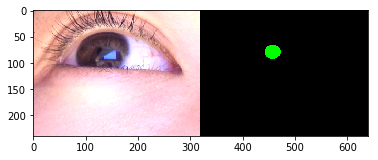

24: Dice eval : 0.382353
data.nnlab/image/matsuda0699.png
(240, 320, 3)
(240, 320, 3)


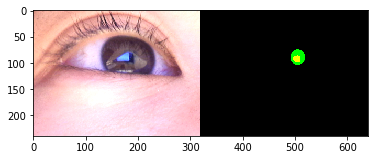

25: Dice eval : 0.431965
data.nnlab/image/matsuda0747.png
(240, 320, 3)
(240, 320, 3)


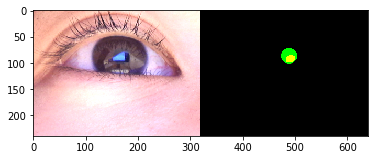

26: Dice eval : 0.000000
data.nnlab/image/matsuda0790.png
(240, 320, 3)
(240, 320, 3)


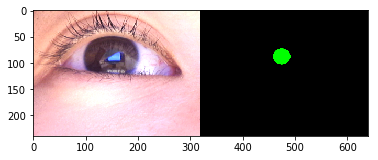

27: Dice eval : 0.000000
data.nnlab/image/matsuda0855.png
(240, 320, 3)
(240, 320, 3)


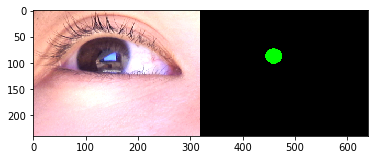

28: Dice eval : 0.554785
data.nnlab/image/mitsuzumi0583.png
(240, 320, 3)
(240, 320, 3)


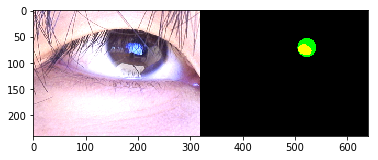

29: Dice eval : 0.415641
data.nnlab/image/mitsuzumi0634.png
(240, 320, 3)
(240, 320, 3)


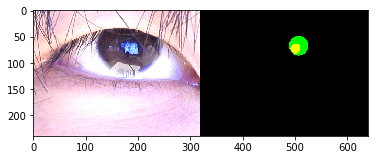

30: Dice eval : 0.256803
data.nnlab/image/mitsuzumi0686.png
(240, 320, 3)
(240, 320, 3)


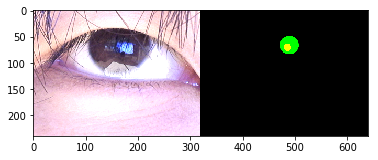

31: Dice eval : 0.500659
data.nnlab/image/mitsuzumi0756.png
(240, 320, 3)
(240, 320, 3)


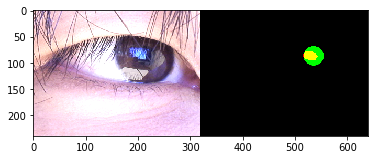

32: Dice eval : 0.654747
data.nnlab/image/mitsuzumi0799.png
(240, 320, 3)
(240, 320, 3)


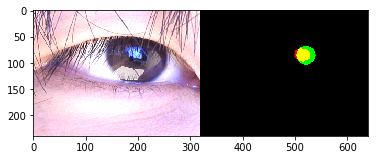

33: Dice eval : 0.689524
data.nnlab/image/mitsuzumi0867.png
(240, 320, 3)
(240, 320, 3)


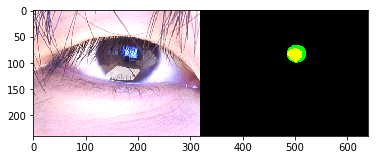

34: Dice eval : 0.633205
data.nnlab/image/mitsuzumi0943.png
(240, 320, 3)
(240, 320, 3)


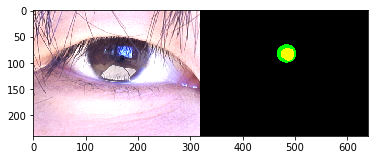

35: Dice eval : 0.000000
data.nnlab/image/ueno0418.png
(240, 320, 3)
(240, 320, 3)


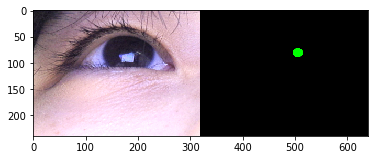

36: Dice eval : 0.000000
data.nnlab/image/ueno0478.png
(240, 320, 3)
(240, 320, 3)


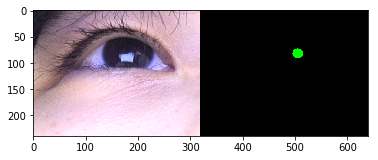

37: Dice eval : 0.145455
data.nnlab/image/ueno0526.png
(240, 320, 3)
(240, 320, 3)


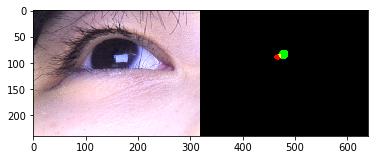

38: Dice eval : 0.169279
data.nnlab/image/ueno0591.png
(240, 320, 3)
(240, 320, 3)


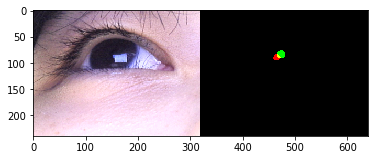

39: Dice eval : 0.000000
data.nnlab/image/ueno0615.png
(240, 320, 3)
(240, 320, 3)


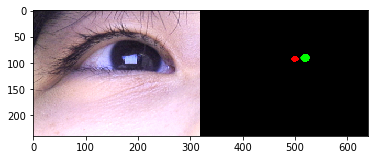

40: Dice eval : 0.523132
data.nnlab/image/ueno0794.png
(240, 320, 4)
(240, 320, 3)


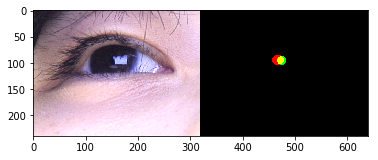

41: Dice eval : 0.861624
data.nnlab/image/watanabe0495.png
(240, 320, 3)
(240, 320, 3)


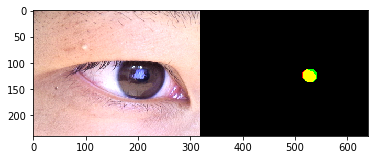

42: Dice eval : 0.800789
data.nnlab/image/watanabe0574.png
(240, 320, 3)
(240, 320, 3)


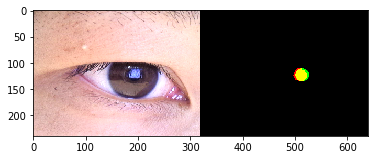

43: Dice eval : 0.820258
data.nnlab/image/watanabe0638.png
(240, 320, 3)
(240, 320, 3)


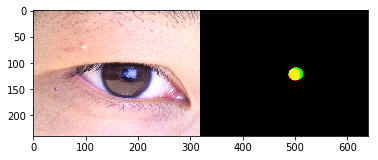

44: Dice eval : 0.838248
data.nnlab/image/watanabe0699.png
(240, 320, 3)
(240, 320, 3)


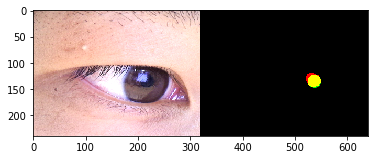

45: Dice eval : 0.747535
data.nnlab/image/watanabe0750.png
(240, 320, 3)
(240, 320, 3)


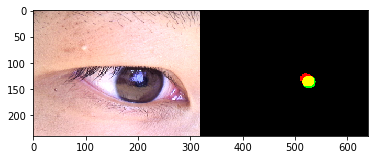

46: Dice eval : 0.700370
data.nnlab/image/watanabe0794.png
(240, 320, 3)
(240, 320, 3)


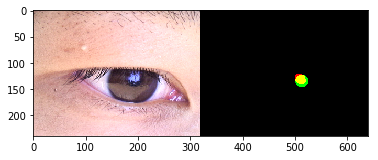

47: Dice eval : 0.816777
data.nnlab/image/watanabe0862.png
(240, 320, 3)
(240, 320, 3)


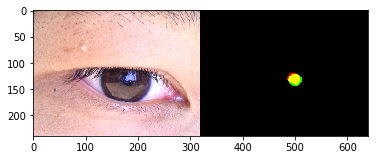

100: Dice eval av. : 0.533807


In [15]:
    from PIL import Image
    import matplotlib.pyplot as plt

    # 学習済みの重みをロード
    epoch = 100
    fname_weights = 'model_weights_%02d.h5'%(epoch)
    fpath_weights = os.path.join(dname_checkpoints, fname_weights)
    model_fcn00.load_weights(fpath_weights)
    print('==> done')

    # テストを開始
    outputs = model_fcn00.predict(X_test)

    # 出力を画像として保存
    dname_outputs = './outputs/'
    if not os.path.isdir(dname_outputs):
        print('create directory: %s'%(dname_outputs))
        os.mkdir(dname_outputs)

    print('saving outputs as images...')
    n = 0
    for i, array in enumerate(outputs):
        array = np.where(array > 0.1, 1, 0) # 二値に変換
        array = array.astype(np.float32)
        img_out = array_to_img(array, dim_ordering)
        # fpath_out = os.path.join(dname_outputs, fnames[i])
        fpath_out = os.path.join(dname_outputs, "%05d.png"%(n))
        img_out.save(fpath_out)
        n = n + 1

    print('==> done')

    n = 0
    dice_eval = []

    for i in range(len(fpaths_xs_test)):
        # テスト画像
        im1 = Image.open(fpaths_xs_test[i])
        im1 = im1.resize((320,240)) 
        # 出力結果
        im2 = Image.open(os.path.join(dname_outputs, "%05d.png"%(n)))
        im2 = im2.resize((320,240))
        # Grond Truth
        im3 = Image.open(fpaths_ys_test[i])
        im3 = im3.resize((320,240))
        im3 = im3.convert('L')
        
        im2_d = np.zeros((240,320,3), 'uint8')
        im2_d[:,:,0] = np.array(im2)
        im2_d[:,:,1] = np.array(im3)
        im2_d[:,:,2] = 0

        # Compute dice coeff
        im2a = np.array(im2)
        im2a[im2a > 0] = 1
        im3a = np.array(im3)
        im3a[im3a > 0] = 1

        overlap_a = np.array(im2a) * np.array(im3a)
        overlap_b = np.array(im2a) + np.array(im3a)
        dice_eval.append(2*sum(sum(overlap_a))/sum(sum(overlap_b)))

        print('%d: Dice eval : %f'%(n,2*sum(sum(overlap_a))/sum(sum(overlap_b))))  
        
        print(fpaths_xs_test[i])
        print(np.array(im1).shape)
        print(np.array(im2_d).shape)
        
        plt.imshow(np.hstack((np.array(im1)[:,:,:3],np.array(im2_d)[:,:,:3])))
        plt.show()

        n = n + 1
    
    print('%d: Dice eval av. : %f'%(epoch,np.mean(np.array(dice_eval))))